In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from sklearn import linear_model

In [2]:
def plot_one(ax, to_plot, color, ecolor, fill_color, label, fmt="x--", fill_between=True, metric='time_per_run', bench_x="bench_x"):
    y_col = metric + '_mean'
    lo_err_col = metric + '_abs_lo_diff'
    hi_err_col = metric + '_abs_hi_diff'
    x = to_plot[bench_x]
    y = to_plot[y_col]
    lo_err = to_plot[lo_err_col]
    hi_err = to_plot[hi_err_col]
    error = [-lo_err, hi_err]
    if fill_between:
        ax.fill_between(x, y + lo_err, y + hi_err, color=fill_color)
    ax.errorbar(x, y, yerr=error, fmt=fmt, color=color, ecolor=ecolor, label=label)

def plot_info_for_axs(df, title, axs, linreg = True, log_scale=False, has_compile=True, bench_x="bench_x"):
    # Setup
    # Assumes existence of bench_x column
    # fig, axs = plt.subplots(3, 1, figsize=(15, 20))

    staged = df[df['benchmark_name'].str.endswith('staged')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff']]
    run = df[df['benchmark_name'].str.endswith('run')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff']]

    # Initial analysis
    plot_one(axs[0], staged, "blue", "black", "#e3e1de", "Compiled")
    plot_one(axs[0], run, "orange", "black", "#e3e1de", "Interpreted")
    axs[0].legend()
    axs[0].set_xlabel("Dynamic Input x")
    axs[0].set_ylabel("Runtime (ns)")
    if log_scale:
        axs[0].set_yscale('log', nonposy='clip')
    # plt.plot(x, y, 'x--', color='blue', label="time/run for staged fib")
    axs[0].set_title(f"{title}: Time/run")

    # Ratio

    joined = staged.join(run.set_index(bench_x), on="bench_x", lsuffix="_staged", rsuffix="_run")
    joined = joined[joined['benchmark_name_staged'].str[:-6] == joined['benchmark_name_run'].str[:-3]]

    axs[1].plot(joined[bench_x], joined['time_per_run_mean_run']/joined['time_per_run_mean_staged'], "x--")
    for i,j in zip(joined[bench_x], joined['time_per_run_mean_run']/joined['time_per_run_mean_staged']):
        axs[1].annotate(str(round(j, 2)),xy=(i,j))

    axs[1].set_xlabel("Dynamic Input x")
    axs[1].set_ylabel("Runtime ratio")
    axs[1].set_title(f"{title}: Ratio of speedup: $t(p, x)/t_p(x)$")

    # Compile + run VS just run
    if has_compile:
        peval = df[df['benchmark_name'].str.endswith('compile')][[bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff']].iloc[0]
        new_staged = (peval + staged).append(peval)
        new_run = run # pd.concat([run, pd.DataFrame([[0, 0, 0, 0]], columns=[bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff'])]) 

        if linreg:
            plot_one(axs[2], new_staged, "blue", "black", "#e3e1de", "Combined run time of the staged version", fmt='.', fill_between=False)
            plot_one(axs[2], new_run, "orange", "black", "#e3e1de", "Combined run time of the non staged version", fmt='.', fill_between=False)

            model_staged = linear_model.LinearRegression()
            model_staged.fit(np.array(new_staged[bench_x]).reshape(-1, 1), new_staged['time_per_run_mean'])
            model_run = linear_model.LinearRegression()
            model_run.fit(np.array(new_run[bench_x]).reshape(-1, 1), new_run['time_per_run_mean'])

            X = np.linspace(0, 100).reshape(-1, 1)
            y_staged = model_staged.predict(X)
            y_run = model_run.predict(X)
            axs[2].plot(X, y_staged, "-", color="cyan", label="Linear model for the combined run time of the staged version")
            axs[2].plot(X, y_run, "-", color="#f7b713", label="Linear model for the run time of the non staged version")

            x_intersection = (model_run.intercept_-model_staged.intercept_) / (model_staged.coef_[0] - model_run.coef_[0])
            y_intersection = model_staged.predict([[x_intersection]])[0]
            axs[2].plot(x_intersection, y_intersection, "o", color="red", label="intersection")
            axs[2].annotate(str((round(x_intersection, 2), round(y_intersection, 2))), xy=(x_intersection, y_intersection))
        else:
            plot_one(axs[2], new_staged, "blue", "black", "#e3e1de", "Combined run time of the staged version", fmt='.--', fill_between=False)
            plot_one(axs[2], new_run, "orange", "black", "#e3e1de", "Combined run time of the non staged version", fmt='.--', fill_between=False)
        axs[2].legend()
        axs[2].set_xlabel("Dynamic Input x")
        axs[2].set_ylabel("Runtime (ns)")
        axs[2].set_title(f"{title}: Time/run: Interpreted VS Compilation + Eval")

    # plt.show()

def plot_info_for(df, title, linreg=True, log_scale=False, has_compile=True):
    fig, axs = plt.subplots(3, 1, figsize=(15, 20))
    plot_info_for_axs(df, title, axs, linreg, log_scale=log_scale, has_compile=has_compile)
    plt.show()


In [3]:
def plot_gc(df):
    fig, axs = plt.subplots(2, 1, figsize=(15, 20))
    staged = df[df['benchmark_name'].str.endswith('staged')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff', 'mGC_per_run_mean', 'mGC_per_run_abs_lo_diff', 'mGC_per_run_abs_hi_diff', 'mjGC_per_run_mean', 'mjGC_per_run_abs_lo_diff', 'mjGC_per_run_abs_hi_diff']]
    run = df[df['benchmark_name'].str.endswith('run')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff', 'mGC_per_run_mean', 'mGC_per_run_abs_lo_diff', 'mGC_per_run_abs_hi_diff', 'mjGC_per_run_mean', 'mjGC_per_run_abs_lo_diff', 'mjGC_per_run_abs_hi_diff']]

    # Garbage collection

    plot_one(axs[0], staged, "blue", "black", "#e3e1de", "Compiled", metric="mGC_per_run", bench_x=bench_x)
    axs[0].legend()
    axs[0].set_xlabel("Dynamic Input x")
    axs[0].set_ylabel("GC Count")
    # axs[0].set_yscale('log', nonposy='clip')
    axs[0].set_title("Compile + Run: mGC/run")

    plot_one(axs[1], staged, "blue", "black", "#e3e1de", "Compiled", metric="mjGC_per_run", bench_x=bench_x)
    axs[1].legend()
    axs[1].set_xlabel("Dynamic Input x")
    axs[1].set_ylabel("GC Count")
    # axs[0].set_yscale('log', nonposy='clip')
    axs[1].set_title("Compile + Run: mjGC/run")

    plt.show()

# Pow

TODO: get data from 2023_3_2_pow_3

2000 runs each

# Pow Map

In [4]:
# 100 runs each.
df_list_map = pd.read_csv("../traces/benchmarks/2023_3_2_pow_3.csv")
df_list_map = df_list_map[df_list_map['benchmark_name'].str.startswith('map_pow')]

In [5]:
df_list_map

,benchmark_name,time_per_run_r2,time_per_run_mean,time_per_run_abs_lo_diff,time_per_run_abs_hi_diff,mWd_per_run_r2,mWd_per_run_mean,mWd_per_run_abs_lo_diff,mWd_per_run_abs_hi_diff,mjWd_per_run_r2,...,mGC_per_run_abs_lo_diff,mGC_per_run_abs_hi_diff,mjGC_per_run_r2,mjGC_per_run_mean,mjGC_per_run_abs_lo_diff,mjGC_per_run_abs_hi_diff,compactions_per_run_r2,compactions_per_run_mean,compactions_per_run_abs_lo_diff,compactions_per_run_abs_hi_diff
0,map_pow_8_512_staged,0.996891,2.969611e+09,-4.463687e+07,4.474471e+07,1.0,643767091.0,-9.536743e-07,1.072884e-06,1.000000,...,-0.266644,0.537369,0.995876,73.886667,-0.576377,1.109825,NaN,0.0,0.0,0.0
1,map_pow_8_512_run,0.996411,3.718636e+09,-6.855184e+07,7.514416e+07,1.0,866900202.0,-1.311302e-06,1.430511e-06,1.000000,...,-0.238856,0.508956,0.996635,83.034444,-0.493091,1.055612,NaN,0.0,0.0,0.0
2,map_pow_8_256_staged,0.970687,7.500114e+08,-3.532857e+07,3.118692e+07,1.0,175850174.0,-2.384186e-07,2.980232e-07,1.000000,...,-0.156968,0.300716,0.997553,45.580000,-0.322370,0.631149,NaN,0.0,0.0,0.0
3,map_pow_8_256_run,0.971805,1.141394e+09,-6.520142e+07,6.308882e+07,1.0,287130485.0,-4.172325e-07,4.768372e-07,1.000000,...,-0.125299,0.261750,0.998527,55.811111,-0.275611,0.580039,NaN,0.0,0.0,0.0
4,map_pow_8_210_staged,0.933627,5.037114e+08,-3.794054e+07,3.813471e+07,1.0,122806054.0,-1.639128e-07,2.235174e-07,1.000000,...,-0.066772,0.140478,0.998616,35.451111,-0.152712,0.345739,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,map_pow_2_4_run,0.986782,2.288758e+06,-7.062547e+04,6.937258e+04,1.0,1146373.0,-1.629815e-09,2.095476e-09,0.999997,...,-0.029862,0.020882,0.948061,0.301111,-0.021765,0.016633,NaN,0.0,0.0,0.0
80,map_pow_2_2_staged,0.963913,9.163790e+05,-3.546170e+04,4.017144e+04,1.0,459371.0,-6.402843e-10,8.149073e-10,0.999971,...,-0.024444,0.017615,0.597531,0.071111,-0.027202,0.016819,NaN,0.0,0.0,0.0
81,map_pow_2_2_run,0.978012,1.326387e+06,-6.023057e+04,6.956675e+04,1.0,650546.0,-8.149073e-10,1.396984e-09,0.999995,...,-0.039225,0.024292,0.793783,0.134444,-0.027172,0.018991,NaN,0.0,0.0,0.0
82,map_pow_2_1_staged,0.772886,7.222549e+05,-2.717016e+04,4.702562e+04,1.0,368784.0,-5.238689e-10,6.402843e-10,0.999987,...,-0.028845,0.019820,0.246795,0.027778,-0.027778,0.025624,NaN,0.0,0.0,0.0


In [ ]:
# 100 runs each.
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 50, 64, 80, 128, 150, 210, 256, 512 ]))
static_arguments = ([8] * len(dyn_arguments) * 2) + ([4] * len(dyn_arguments) * 2) + [2] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map['bench_s'] = static_arguments
df_list_map['bench_d'] = dyn_arguments * 3


In [43]:
def plot_for(df, bench_x="bench_x", mean_offset=0, abs_lo_offset=0, abs_hi_offset=0):
    fig, axs = plt.subplots(4, 1, figsize=(15, 20))
    staged = df[df['benchmark_name'].str.endswith('staged')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff', 'mGC_per_run_mean', 'mGC_per_run_abs_lo_diff', 'mGC_per_run_abs_hi_diff', 'mjGC_per_run_mean', 'mjGC_per_run_abs_lo_diff', 'mjGC_per_run_abs_hi_diff']]
    run = df[df['benchmark_name'].str.endswith('run')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff', 'mGC_per_run_mean', 'mGC_per_run_abs_lo_diff', 'mGC_per_run_abs_hi_diff', 'mjGC_per_run_mean', 'mjGC_per_run_abs_lo_diff', 'mjGC_per_run_abs_hi_diff']]

    # Initial analysis
    plot_one(axs[0], staged, "blue", "black", "#e3e1de", "Compiled", bench_x=bench_x)
    plot_one(axs[0], run, "orange", "black", "#e3e1de", "Interpreted", bench_x=bench_x)
    axs[0].legend()
    axs[0].set_xlabel(bench_x)
    axs[0].set_ylabel("Runtime (ns)")
    # axs[0].set_yscale('log', nonposy='clip')
    # plt.plot(x, y, 'x--', color='blue', label="time/run for staged fib")
    axs[0].set_title("Map pow on a list of length x, compile + run: Time/run")

    # pow10 compile time 2.369822e+06	-150726.975394	150175.942413: info from prev experiments
    staged['time_per_run_mean'] += mean_offset
    staged['time_per_run_abs_lo_diff'] += abs_lo_offset
    staged['time_per_run_abs_hi_diff'] += abs_hi_offset

    joined = staged.join(run.set_index(bench_x), on=bench_x, lsuffix="_staged", rsuffix="_run")
    joined = joined[joined['benchmark_name_staged'].str[:-6] == joined['benchmark_name_run'].str[:-3]]

    axs[1].plot(joined[bench_x], joined['time_per_run_mean_run']/joined['time_per_run_mean_staged'], "x--")
    for i,j in zip(joined[bench_x], joined['time_per_run_mean_run']/joined['time_per_run_mean_staged']):
        axs[1].annotate(str((round(i, 0), round(j, 2))),xy=(i,j))
    
    axs[1].set_xlabel(bench_x)
    axs[1].set_ylabel("Runtime ratio")
    axs[1].set_title(f"Ratio of speedup (ish): $t(p, x)/t_p(x)$")

    # Garbage collection

    plot_one(axs[2], staged, "blue", "black", "#e3e1de", "Compiled", metric="mGC_per_run", bench_x=bench_x)
    plot_one(axs[2], run, "orange", "black", "#e3e1de", "Interpreted", metric="mGC_per_run", bench_x=bench_x)
    axs[2].legend()
    axs[2].set_xlabel(bench_x)
    axs[2].set_ylabel("GC Count")
    # axs[0].set_yscale('log', nonposy='clip')
    axs[2].set_title("Compile + Run: mGC/run")

    plot_one(axs[3], staged, "blue", "black", "#e3e1de", "Compiled", metric="mjGC_per_run", bench_x=bench_x)
    plot_one(axs[3], run, "orange", "black", "#e3e1de", "Interpreted", metric="mjGC_per_run", bench_x=bench_x)
    axs[3].legend()
    axs[3].set_xlabel(bench_x)
    axs[3].set_ylabel("GC Count")
    # axs[0].set_yscale('log', nonposy='clip')
    axs[3].set_title("Compile + Run: mGC/run")

    plt.show()

In [9]:
# plot_for(df_list_map[df_list_map['benchmark_name'].str.match('.*_210_.*')], 'bench_s')


In [ ]:
plot_for(df_list_map[df_list_map['benchmark_name'].str.startswith('map_pow_8')], 'bench_d')

# Pow Map bis

In [11]:
# 100 runs each.
df_list_map_2 = pd.read_csv("../traces/benchmarks/2023_3_3_pow_4.csv")
df_list_map_2 = df_list_map_2[df_list_map_2['benchmark_name'].str.startswith('map_pow')]
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 50, 64, 80, 128, 150, 210, 256, 512 ]))
static_arguments = ([64] * len(dyn_arguments) * 2) + ([32] * len(dyn_arguments) * 2) + [16] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map_2['bench_s'] = static_arguments
df_list_map_2['bench_d'] = dyn_arguments * 3


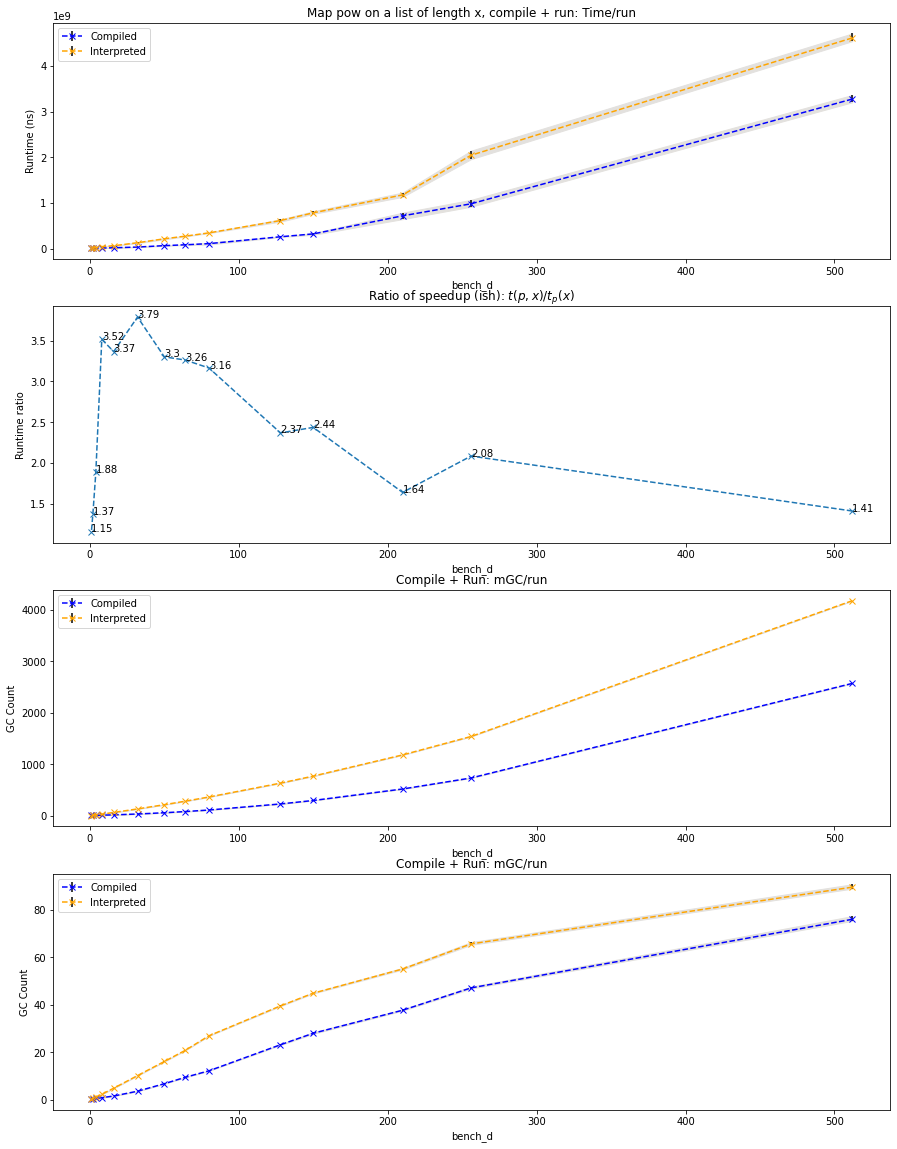

In [29]:
plot_for(df_list_map_2[df_list_map_2['benchmark_name'].str.startswith('map_pow_16')], 'bench_d')

In [13]:
df_list_map_2

,benchmark_name,time_per_run_r2,time_per_run_mean,time_per_run_abs_lo_diff,time_per_run_abs_hi_diff,mWd_per_run_r2,mWd_per_run_mean,mWd_per_run_abs_lo_diff,mWd_per_run_abs_hi_diff,mjWd_per_run_r2,...,mjGC_per_run_r2,mjGC_per_run_mean,mjGC_per_run_abs_lo_diff,mjGC_per_run_abs_hi_diff,compactions_per_run_r2,compactions_per_run_mean,compactions_per_run_abs_lo_diff,compactions_per_run_abs_hi_diff,bench_s,bench_d
0,map_pow_64_512_staged,0.976893,4.332687e+09,-1.930824e+08,2.321658e+08,1.0,7.869208e+08,-1.072884e-06,1.311302e-06,1.000000,...,0.995930,80.504444,-0.624722,1.270349,NaN,0.0,0.0,0.0,64,512
1,map_pow_64_512_run,0.979290,9.377337e+09,-4.682640e+08,4.952127e+08,1.0,2.372897e+09,-3.337860e-06,4.291534e-06,1.000000,...,0.997399,132.254444,-0.864671,1.682088,NaN,0.0,0.0,0.0,64,512
2,map_pow_64_256_staged,0.991673,1.058211e+09,-2.748827e+07,2.252172e+07,1.0,2.509232e+08,-3.576279e-07,4.470348e-07,1.000000,...,0.996956,53.617778,-0.367584,0.742931,NaN,0.0,0.0,0.0,64,256
3,map_pow_64_256_run,0.997671,3.525561e+09,-4.489069e+07,4.738796e+07,1.0,1.040129e+09,-1.430511e-06,1.907349e-06,1.000000,...,0.999302,116.842222,-0.363607,0.742360,NaN,0.0,0.0,0.0,64,256
4,map_pow_64_210_staged,0.816952,8.167535e+08,-5.073824e+07,8.729151e+07,1.0,1.856459e+08,-2.682209e-07,3.278255e-07,1.000000,...,0.997358,43.001111,-0.275738,0.584716,NaN,0.0,0.0,0.0,64,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,map_pow_16_4_run,0.945188,2.119156e+07,-1.544301e+06,1.565820e+06,1.0,4.087774e+06,-5.587935e-09,7.916242e-09,0.999998,...,0.994649,1.134444,-0.028656,0.019533,NaN,0.0,0.0,0.0,16,4
80,map_pow_16_2_staged,0.924301,7.622413e+06,-3.991863e+05,6.828213e+05,1.0,1.754937e+06,-2.561137e-09,3.492460e-09,0.999996,...,0.956647,0.421111,-0.030061,0.019054,NaN,0.0,0.0,0.0,16,2
81,map_pow_16_2_run,0.857287,1.043151e+07,-1.469586e+06,1.534318e+06,1.0,2.121211e+06,-2.793968e-09,4.190952e-09,0.999994,...,0.979521,0.575556,-0.025439,0.019579,NaN,0.0,0.0,0.0,16,2
82,map_pow_16_1_staged,0.867299,7.291902e+06,-5.233232e+05,8.421569e+05,1.0,1.599183e+06,-2.561137e-09,2.793968e-09,0.999984,...,0.955596,0.353333,-0.024444,0.018489,NaN,0.0,0.0,0.0,16,1


# No shifting

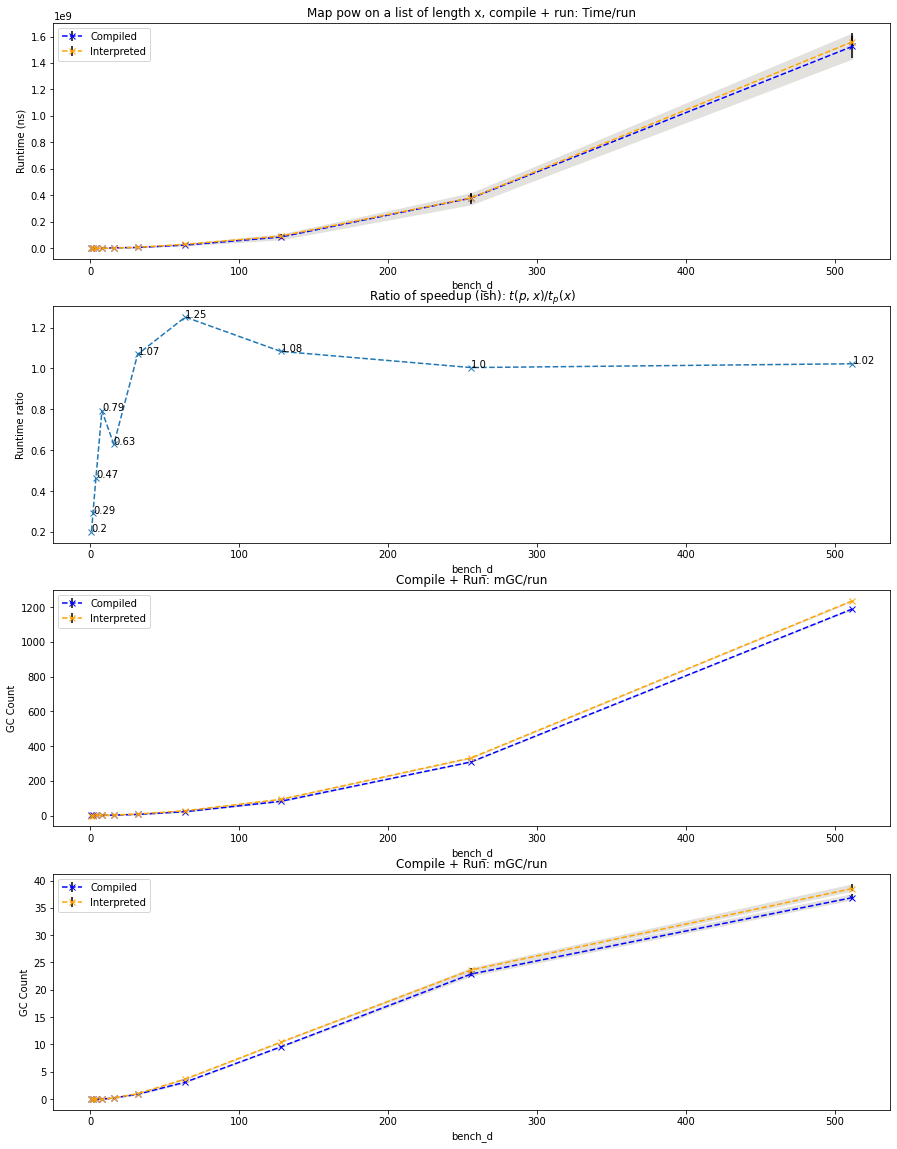

In [14]:
# 100 runs each.
df_list_map_3 = pd.read_csv("../traces/benchmarks/2023_3_3_pow_5_100_runs_without_quadratic.csv")
df_list_map_3 = df_list_map_3[df_list_map_3['benchmark_name'].str.startswith('map_pow')]
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ]))
static_arguments = [16] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map_3['bench_s'] = static_arguments
df_list_map_3['bench_d'] = dyn_arguments

plot_for(df_list_map_3[df_list_map_3['benchmark_name'].str.startswith('map_pow_16')], 'bench_d')

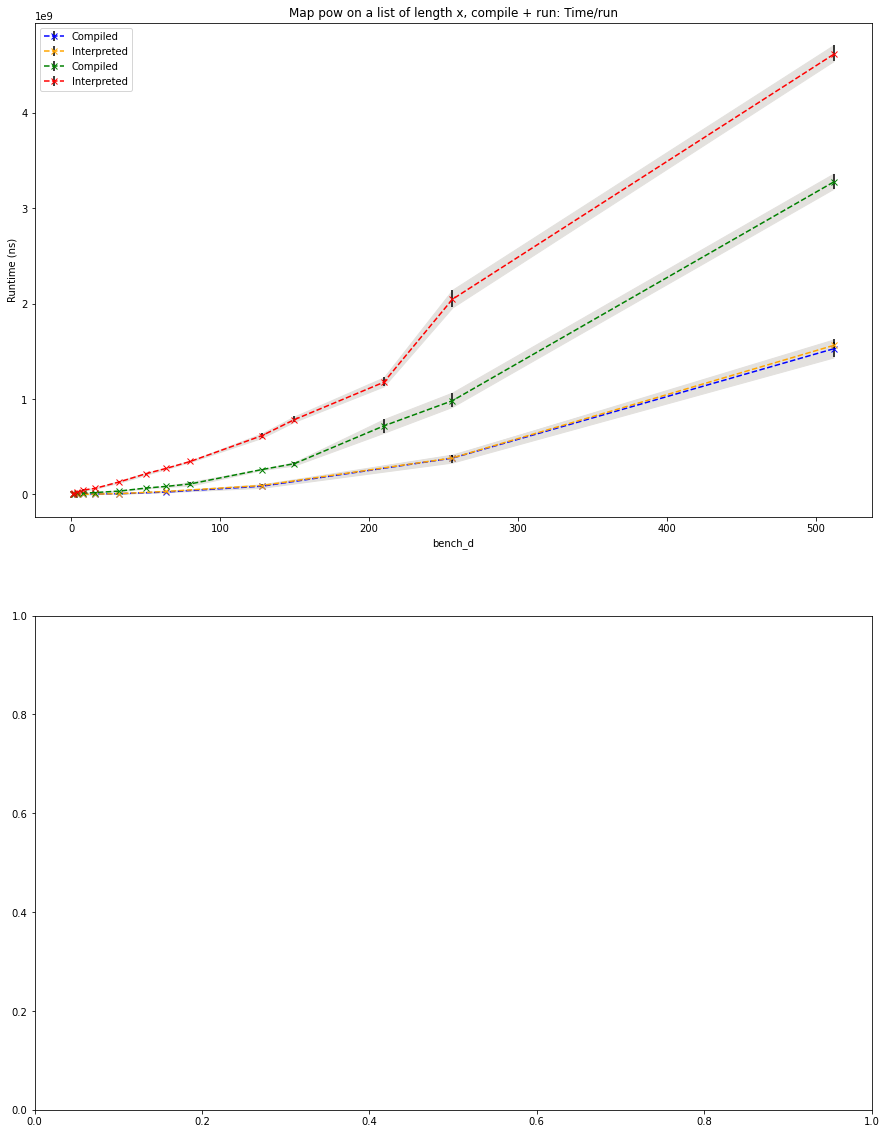

In [15]:
def plot_for_2(df, df2, bench_x="bench_x"):
    fig, axs = plt.subplots(2, 1, figsize=(15, 20))
    staged = df[df['benchmark_name'].str.endswith('staged')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff', 'mGC_per_run_mean', 'mGC_per_run_abs_lo_diff', 'mGC_per_run_abs_hi_diff', 'mjGC_per_run_mean', 'mjGC_per_run_abs_lo_diff', 'mjGC_per_run_abs_hi_diff']]
    run = df[df['benchmark_name'].str.endswith('run')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff', 'mGC_per_run_mean', 'mGC_per_run_abs_lo_diff', 'mGC_per_run_abs_hi_diff', 'mjGC_per_run_mean', 'mjGC_per_run_abs_lo_diff', 'mjGC_per_run_abs_hi_diff']]

    staged_2 = df2[df2['benchmark_name'].str.endswith('staged')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff', 'mGC_per_run_mean', 'mGC_per_run_abs_lo_diff', 'mGC_per_run_abs_hi_diff', 'mjGC_per_run_mean', 'mjGC_per_run_abs_lo_diff', 'mjGC_per_run_abs_hi_diff']]
    run_2 = df2[df2['benchmark_name'].str.endswith('run')][['benchmark_name', bench_x, 'time_per_run_mean', 'time_per_run_abs_lo_diff', 'time_per_run_abs_hi_diff', 'mGC_per_run_mean', 'mGC_per_run_abs_lo_diff', 'mGC_per_run_abs_hi_diff', 'mjGC_per_run_mean', 'mjGC_per_run_abs_lo_diff', 'mjGC_per_run_abs_hi_diff']]

    # Initial analysis
    plot_one(axs[0], staged, "blue", "black", "#e3e1de", "Compiled", bench_x=bench_x)
    plot_one(axs[0], run, "orange", "black", "#e3e1de", "Interpreted", bench_x=bench_x)
    plot_one(axs[0], staged_2, "green", "black", "#e3e1de", "Compiled", bench_x=bench_x)
    plot_one(axs[0], run_2, "red", "black", "#e3e1de", "Interpreted", bench_x=bench_x)
    axs[0].legend()
    axs[0].set_xlabel(bench_x)
    axs[0].set_ylabel("Runtime (ns)")
    # axs[0].set_yscale('log', nonposy='clip')
    # plt.plot(x, y, 'x--', color='blue', label="time/run for staged fib")
    axs[0].set_title("Map pow on a list of length x, compile + run: Time/run")


    plt.show()
plot_for_2(df_list_map_3[df_list_map_3['benchmark_name'].str.startswith('map_pow_16')], df_list_map_2[df_list_map_2['benchmark_name'].str.startswith('map_pow_16')], 'bench_d')

# Iter Pow on 0

In [16]:
# 100 runs each.
df_list_map_3 = pd.read_csv("../traces/benchmarks/2023_3_3_pow_5_100_runs_without_quadratic_init_0_1.csv")
df_list_map_3 = df_list_map_3[df_list_map_3['benchmark_name'].str.startswith('iter_pow')]
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ]))
static_arguments = [16] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map_3['bench_s'] = static_arguments
df_list_map_3['bench_d'] = dyn_arguments

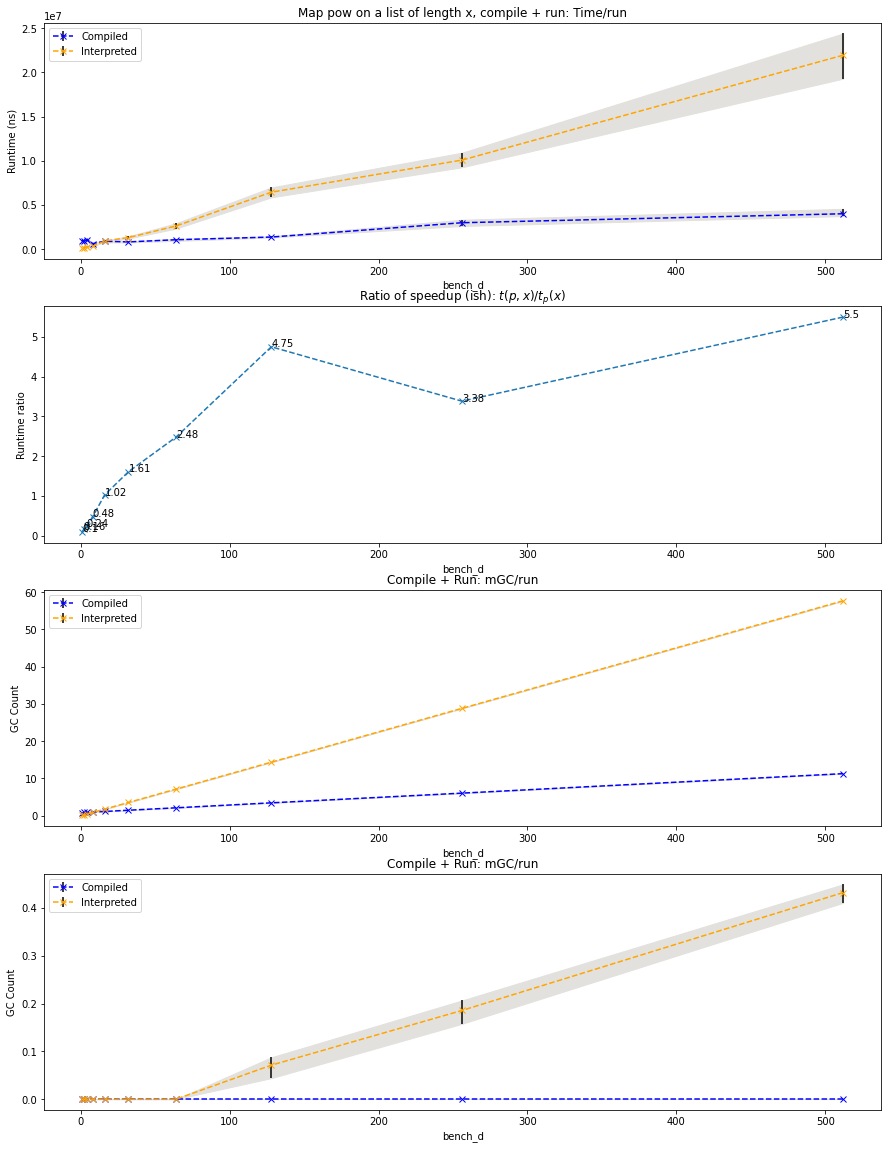

In [17]:
plot_for(df_list_map_3[df_list_map_3['benchmark_name'].str.startswith('iter_pow_16')], 'bench_d')

# Pow Map returning units

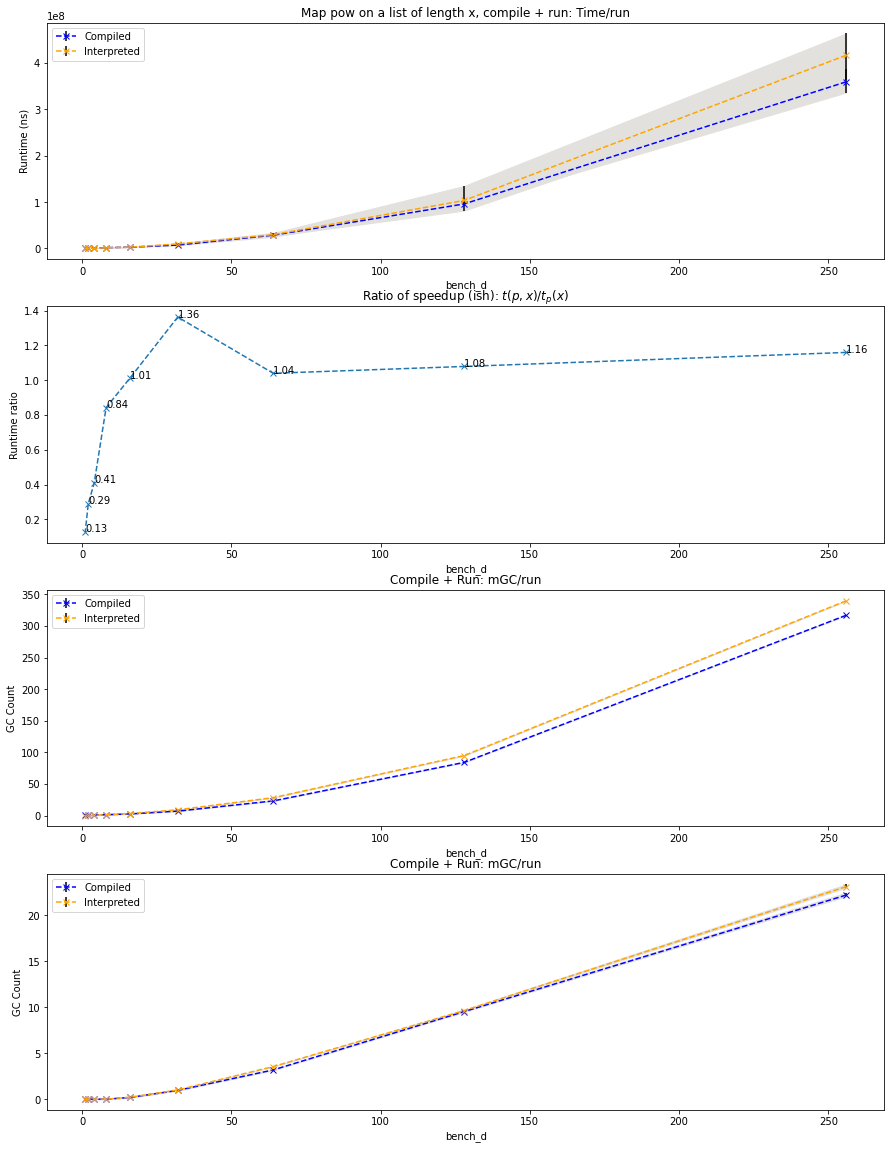

In [18]:
# 100 runs each.
df_list_map_3 = pd.read_csv("../traces/benchmarks/2023_3_3_pow_map_run_to_unit.csv")
df_list_map_3 = df_list_map_3[df_list_map_3['benchmark_name'].str.startswith('map_pow')]
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 64, 128, 256 ]))
static_arguments = [16] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map_3['bench_s'] = static_arguments
df_list_map_3['bench_d'] = dyn_arguments
plot_for(df_list_map_3[df_list_map_3['benchmark_name'].str.startswith('map_pow_16')], 'bench_d')

# Pow Iter with dummy match

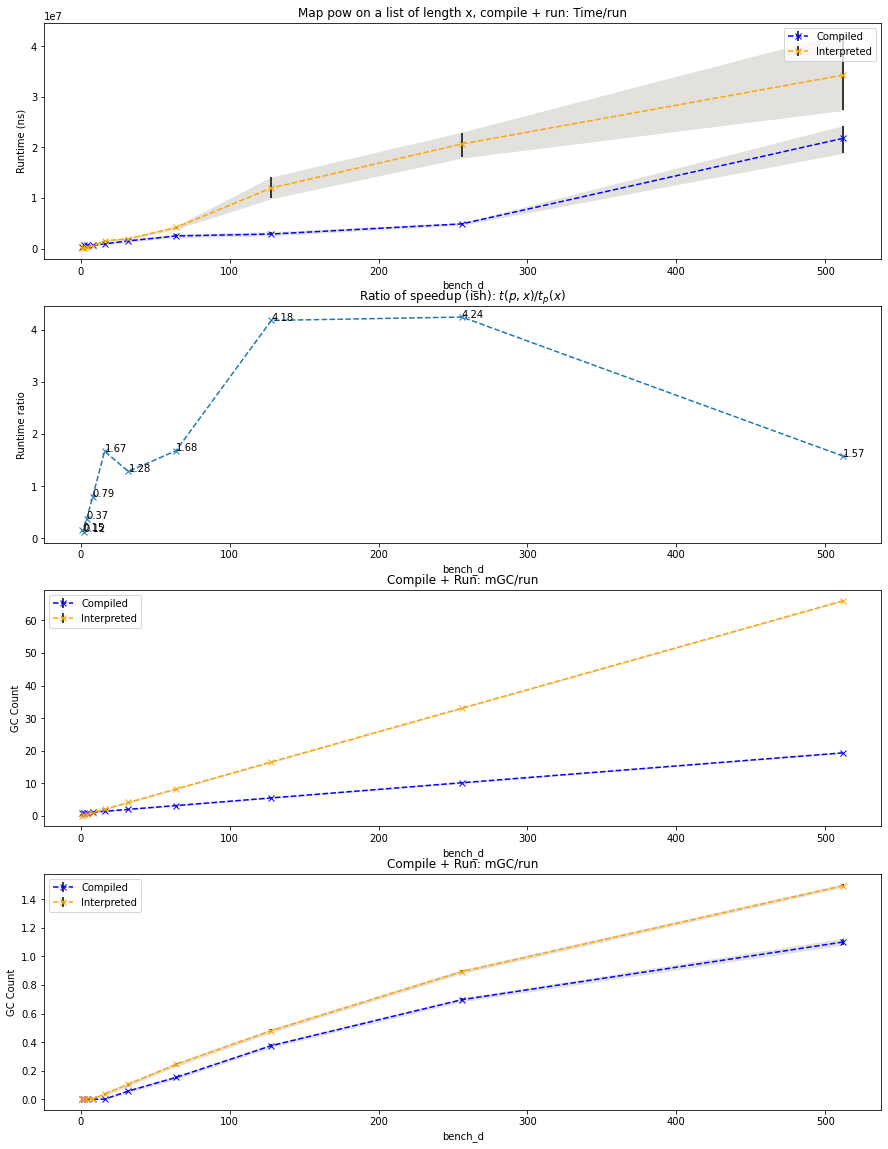

In [26]:
# 100 runs each.
df_list_map_5 = pd.read_csv("../traces/benchmarks/2023_3_3_pow_map_run_unit_to_list_2.csv")
df_list_map_5 = df_list_map_5[df_list_map_5['benchmark_name'].str.startswith('iter_pow')]
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ]))
static_arguments = [16] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map_5['bench_s'] = static_arguments
df_list_map_5['bench_d'] = dyn_arguments
plot_for(df_list_map_5[df_list_map_5['benchmark_name'].str.startswith('iter_pow_16')], 'bench_d')

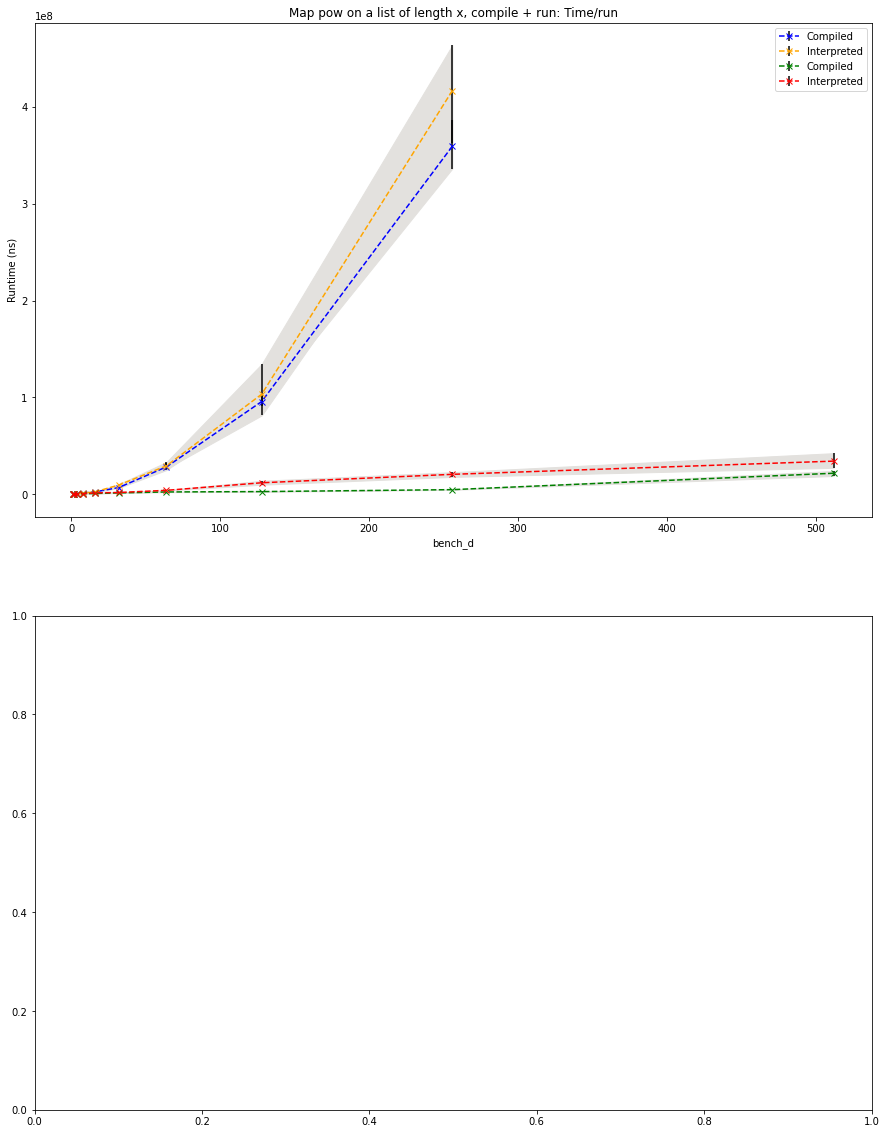

In [27]:
plot_for_2(df_list_map_3, df_list_map_5, 'bench_d')

In [21]:
df_list_map_5

,benchmark_name,time_per_run_r2,time_per_run_mean,time_per_run_abs_lo_diff,time_per_run_abs_hi_diff,mWd_per_run_r2,mWd_per_run_mean,mWd_per_run_abs_lo_diff,mWd_per_run_abs_hi_diff,mjWd_per_run_r2,...,mjGC_per_run_r2,mjGC_per_run_mean,mjGC_per_run_abs_lo_diff,mjGC_per_run_abs_hi_diff,compactions_per_run_r2,compactions_per_run_mean,compactions_per_run_abs_lo_diff,compactions_per_run_abs_hi_diff,bench_s,bench_d
0,iter_pow_16_512_staged,0.853428,2.179685e+07,-2.856927e+06,2.386158e+06,1.0,4937127.0,-6.519258e-09,8.381903e-09,0.999997,...,0.993282,1.101020,-0.017919,0.022744,NaN,0.0,0.0,0.0,16,512
1,iter_pow_16_512_run,0.617241,3.429918e+07,-6.909755e+06,8.230036e+06,1.0,17119491.0,-2.235174e-08,2.607703e-08,0.999998,...,0.998997,1.495714,-0.008725,0.009777,NaN,0.0,0.0,0.0,16,512
2,iter_pow_16_256_staged,0.989168,4.872154e+06,-1.552394e+05,1.400430e+05,1.0,2587559.0,-3.725290e-09,3.725290e-09,0.999982,...,0.994241,0.696939,-0.011924,0.009227,NaN,0.0,0.0,0.0,16,256
3,iter_pow_16_256_run,0.858488,2.067492e+07,-2.674776e+06,2.248059e+06,1.0,8564995.0,-1.117587e-08,1.490116e-08,0.999994,...,0.996617,0.893673,-0.009977,0.010567,NaN,0.0,0.0,0.0,16,256
4,iter_pow_16_128_staged,0.787607,2.864571e+06,-2.451005e+05,3.506156e+05,1.0,1412775.0,-1.862645e-09,2.328306e-09,0.999946,...,0.984075,0.374898,-0.009707,0.008178,NaN,0.0,0.0,0.0,16,128
5,iter_pow_16_128_run,0.764232,1.197054e+07,-2.021454e+06,2.078895e+06,1.0,4287747.0,-5.587935e-09,7.450581e-09,0.999991,...,0.990474,0.480408,-0.011435,0.008462,NaN,0.0,0.0,0.0,16,128
6,iter_pow_16_64_staged,0.767313,2.484684e+06,-2.168906e+05,3.071341e+05,1.0,825453.0,-1.280569e-09,1.280569e-09,0.998686,...,0.937103,0.152245,-0.009565,0.008404,NaN,0.0,0.0,0.0,16,64
7,iter_pow_16_64_run,0.956554,4.167522e+06,-2.334267e+05,2.165173e+05,1.0,2149193.0,-3.259629e-09,3.259629e-09,0.999947,...,0.963867,0.243469,-0.011861,0.008629,NaN,0.0,0.0,0.0,16,64
8,iter_pow_16_32_staged,0.796934,1.514221e+06,-1.507110e+05,1.991710e+05,1.0,531821.0,-6.984919e-10,9.313226e-10,0.976191,...,0.727567,0.056939,-0.008062,0.009123,NaN,0.0,0.0,0.0,16,32
9,iter_pow_16_32_run,0.947073,1.935873e+06,-8.100250e+04,9.108824e+04,1.0,1079945.0,-1.629815e-09,1.629815e-09,0.999504,...,0.868046,0.104898,-0.011089,0.009368,NaN,0.0,0.0,0.0,16,32


# Pow with dummy list argument



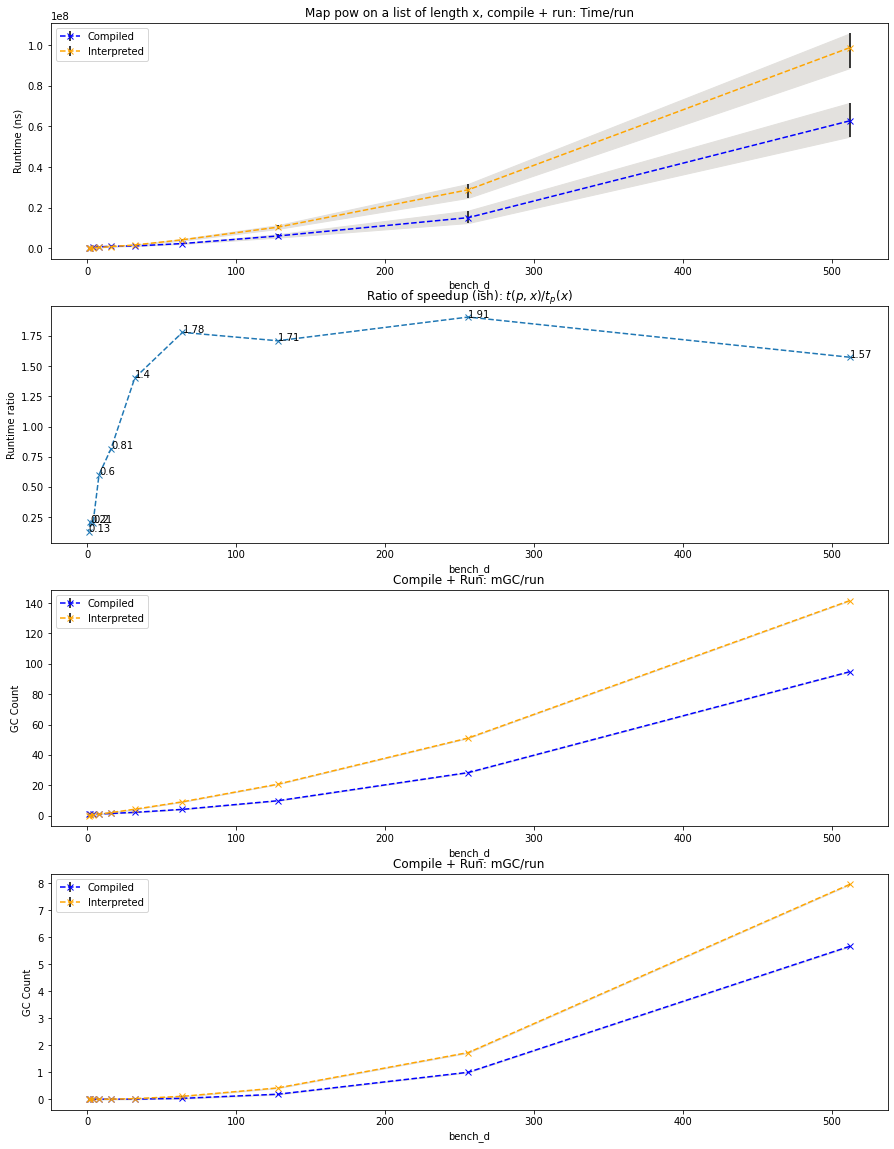

In [22]:
# 100 runs each.
df_list_map_6 = pd.read_csv("../traces/benchmarks/2023_3_3_pow_map_run_unit_to_list_3_with_dummy_list_argument.csv")
df_list_map_6 = df_list_map_6[df_list_map_6['benchmark_name'].str.startswith('iter_pow')]
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ]))
static_arguments = [16] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map_6['bench_s'] = static_arguments
df_list_map_6['bench_d'] = dyn_arguments
plot_for(df_list_map_6[df_list_map_6['benchmark_name'].str.startswith('iter_pow_16')], 'bench_d')

In [23]:
df_list_map_6

,benchmark_name,time_per_run_r2,time_per_run_mean,time_per_run_abs_lo_diff,time_per_run_abs_hi_diff,mWd_per_run_r2,mWd_per_run_mean,mWd_per_run_abs_lo_diff,mWd_per_run_abs_hi_diff,mjWd_per_run_r2,...,mjGC_per_run_r2,mjGC_per_run_mean,mjGC_per_run_abs_lo_diff,mjGC_per_run_abs_hi_diff,compactions_per_run_r2,compactions_per_run_mean,compactions_per_run_abs_lo_diff,compactions_per_run_abs_hi_diff,bench_s,bench_d
0,iter_pow_16_512_staged,0.784173,6.274015e+07,-7.787738e+06,8.840651e+06,1.0,24113316.0,-3.725290e-08,3.725290e-08,0.999994,...,0.999887,5.657959,-0.011558,0.009008,NaN,0.0,0.0,0.0,16,512
1,iter_pow_16_512_run,0.886365,9.872921e+07,-1.004959e+07,7.043653e+06,1.0,36083862.0,-5.215406e-08,5.960464e-08,0.999999,...,0.999960,7.951020,-0.007062,0.007029,NaN,0.0,0.0,0.0,16,512
2,iter_pow_16_256_staged,0.348177,1.513422e+07,-2.647000e+06,3.461543e+06,1.0,7325348.0,-1.024455e-08,1.303852e-08,0.999914,...,0.996446,0.996122,-0.006217,0.003181,NaN,0.0,0.0,0.0,16,256
3,iter_pow_16_256_run,0.852346,2.884645e+07,-3.973132e+06,2.917920e+06,1.0,13196694.0,-1.676381e-08,2.235174e-08,0.999996,...,0.998896,1.726122,-0.011948,0.008887,NaN,0.0,0.0,0.0,16,256
4,iter_pow_16_128_staged,0.843960,6.104871e+06,-8.165912e+05,8.374595e+05,1.0,2568792.0,-3.259629e-09,4.656613e-09,0.999792,...,0.943719,0.182245,-0.011519,0.009351,NaN,0.0,0.0,0.0,16,128
5,iter_pow_16_128_run,0.902250,1.043779e+07,-8.679468e+05,9.914794e+05,1.0,5390524.0,-6.519258e-09,8.381903e-09,0.999969,...,0.987473,0.415714,-0.009491,0.007720,NaN,0.0,0.0,0.0,16,128
6,iter_pow_16_64_staged,0.876990,2.377552e+06,-1.652517e+05,2.032562e+05,1.0,1099656.0,-1.396984e-09,1.862645e-09,0.999541,...,0.486111,0.030000,-0.013440,0.008912,NaN,0.0,0.0,0.0,16,64
7,iter_pow_16_64_run,0.884504,4.230091e+06,-3.865495e+05,4.001925e+05,1.0,2396588.0,-3.259629e-09,4.190952e-09,0.999738,...,0.868046,0.104898,-0.011183,0.009034,NaN,0.0,0.0,0.0,16,64
8,iter_pow_16_32_staged,0.800893,1.193354e+06,-6.826289e+04,1.086329e+05,1.0,592416.0,-8.149073e-10,1.047738e-09,0.999731,...,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,16,32
9,iter_pow_16_32_run,0.814141,1.673013e+06,-1.119517e+05,1.409933e+05,1.0,1126948.0,-1.396984e-09,1.862645e-09,0.999591,...,0.301506,0.018367,-0.013401,0.011308,NaN,0.0,0.0,0.0,16,32


# Pow with dummy list argument and match

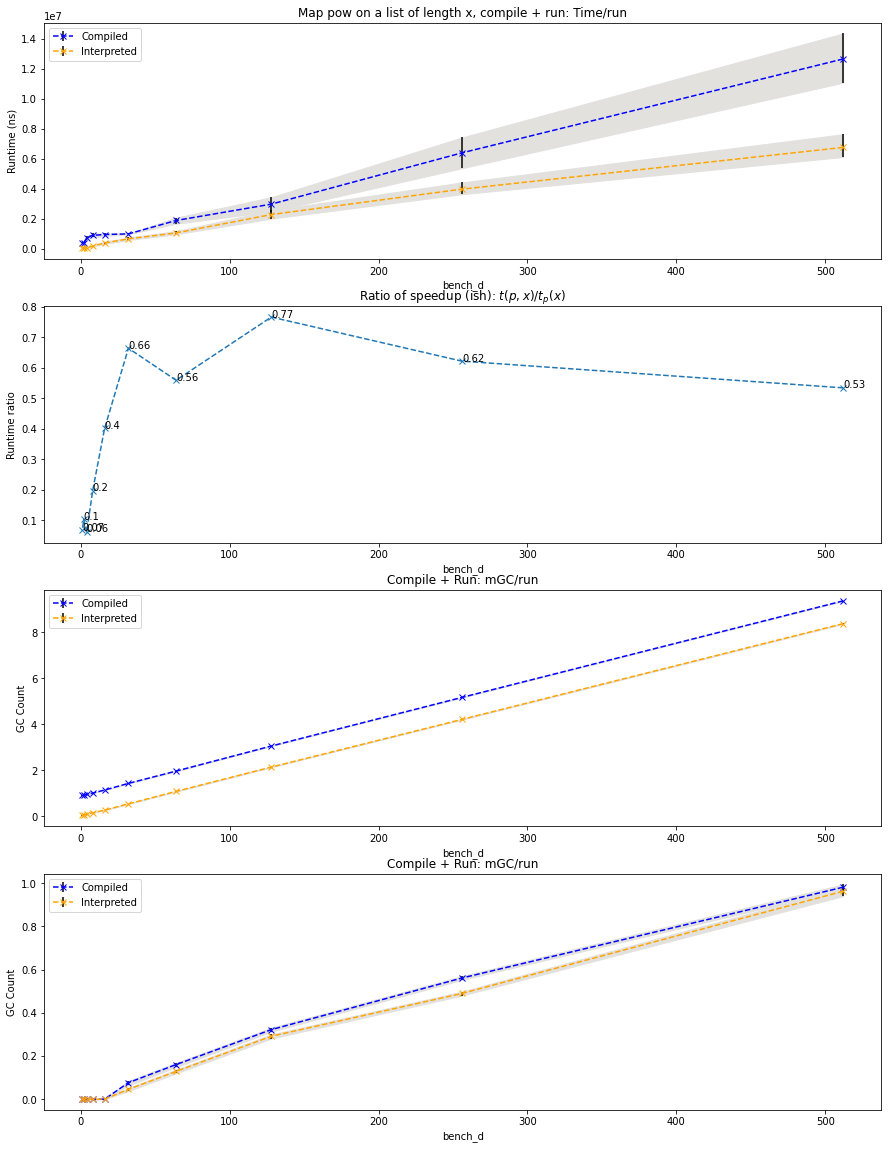

In [24]:
# 100 runs each.
df_list_map_6 = pd.read_csv("../traces/benchmarks/2023_3_3_pow_map_run_unit_to_list_4_with_dummy_list_and_match.csv")
df_list_map_6 = df_list_map_6[df_list_map_6['benchmark_name'].str.startswith('iter_pow')]
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ]))
static_arguments = [16] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map_6['bench_s'] = static_arguments
df_list_map_6['bench_d'] = dyn_arguments
plot_for(df_list_map_6[df_list_map_6['benchmark_name'].str.startswith('iter_pow_16')], 'bench_d')

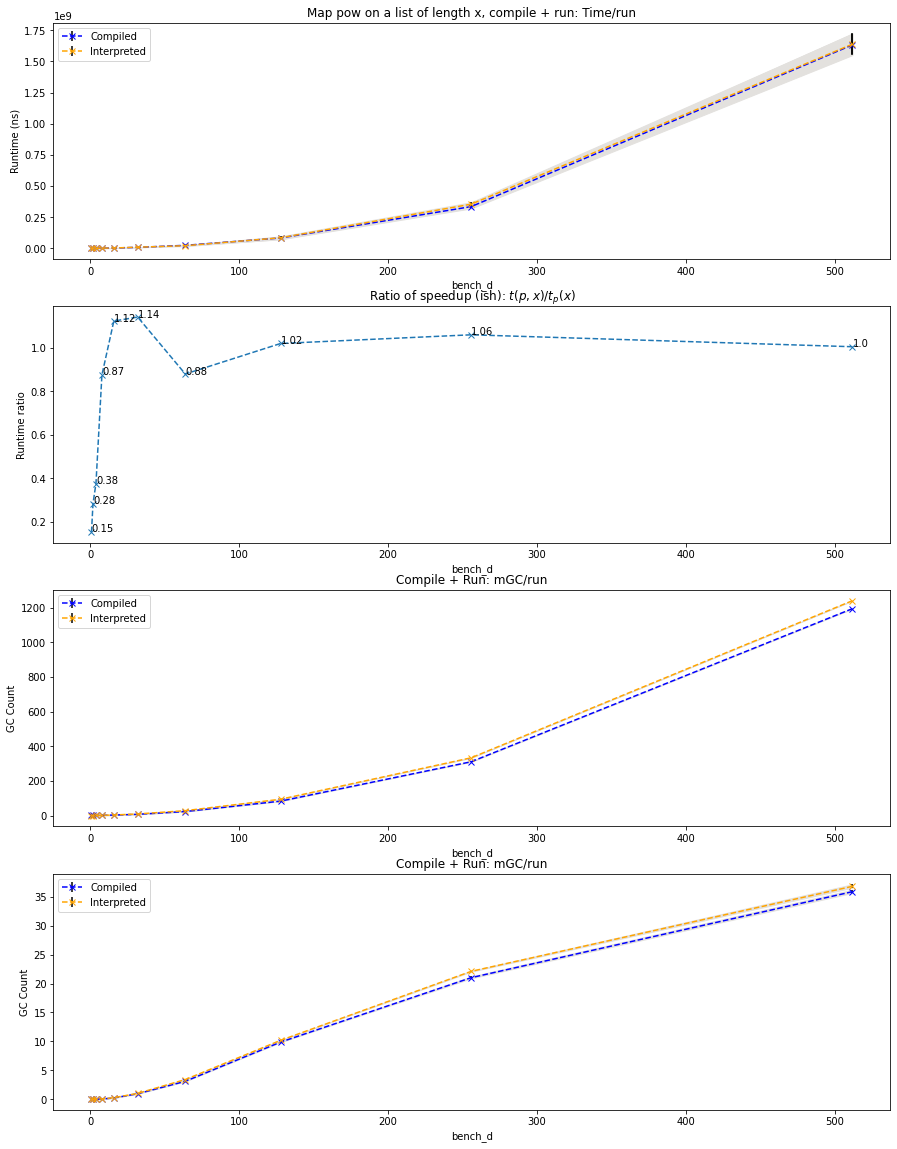

In [25]:
# Try again with more sensible choices

# 100 runs each.
df_list_map_6 = pd.read_csv("../traces/benchmarks/2023_3_3_pow_map_run_unit_to_list_4_with_dummy_list_and_match_2.csv")
df_list_map_6 = df_list_map_6[df_list_map_6['benchmark_name'].str.startswith('iter_pow')]
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ]))
static_arguments = [16] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map_6['bench_s'] = static_arguments
df_list_map_6['bench_d'] = dyn_arguments
plot_for(df_list_map_6[df_list_map_6['benchmark_name'].str.startswith('iter_pow_16')], 'bench_d')

# Pow: 1000 runs

In [41]:
# data collected ad hoc with 2000 trials on pow_16_compile
mean_offset = -548.28 * 1e3
lo_offset = -33.11 * 1e3
hi_offset = 35.91 * 1e3

In [32]:
# 100 runs each.
df_list_map_7 = pd.read_csv("../traces/benchmarks/2023_3_3_pow_map_1000_big_run.csv")
df_list_map_7 = df_list_map_7[df_list_map_7['benchmark_name'].str.startswith('map_pow')]


In [33]:
df_list_map_7

,benchmark_name,time_per_run_r2,time_per_run_mean,time_per_run_abs_lo_diff,time_per_run_abs_hi_diff,mWd_per_run_r2,mWd_per_run_mean,mWd_per_run_abs_lo_diff,mWd_per_run_abs_hi_diff,mjWd_per_run_r2,...,mGC_per_run_abs_lo_diff,mGC_per_run_abs_hi_diff,mjGC_per_run_r2,mjGC_per_run_mean,mjGC_per_run_abs_lo_diff,mjGC_per_run_abs_hi_diff,compactions_per_run_r2,compactions_per_run_mean,compactions_per_run_abs_lo_diff,compactions_per_run_abs_hi_diff
0,map_pow_16_512_staged,0.975042,1.699559e+09,-4.252999e+07,5.474914e+07,1.0,306961974.0,-4.172325e-07,6.556511e-07,1.000000,...,-0.050461,0.075912,0.999063,35.807771,-1.025421e-01,1.475999e-01,NaN,0.0,0.0,0.0
1,map_pow_16_512_run,0.962214,1.765589e+09,-5.457687e+07,6.248417e+07,1.0,319114224.0,-4.172325e-07,6.556511e-07,1.000000,...,-0.027934,0.043012,0.999356,35.290804,-5.826396e-02,8.995761e-02,NaN,0.0,0.0,0.0
2,map_pow_16_256_staged,0.941862,4.555493e+08,-2.263352e+07,2.454405e+07,1.0,77970102.0,-1.192093e-07,1.490116e-07,1.000000,...,-0.031988,0.042078,0.999505,21.242348,-6.805025e-02,8.290231e-02,NaN,0.0,0.0,0.0
3,map_pow_16_256_run,0.948766,4.910721e+08,-2.270705e+07,2.173856e+07,1.0,83932528.0,-1.043081e-07,1.937151e-07,1.000000,...,-0.012291,0.018502,0.999766,21.799050,-2.727872e-02,4.405928e-02,NaN,0.0,0.0,0.0
4,map_pow_16_128_staged,0.816071,9.530642e+07,-8.303298e+06,7.700981e+06,1.0,20195754.0,-2.235174e-08,4.470348e-08,1.000000,...,-0.015226,0.022778,0.999218,9.495046,-3.306946e-02,5.018592e-02,NaN,0.0,0.0,0.0
5,map_pow_16_128_run,0.830066,1.077309e+08,-8.096124e+06,8.607923e+06,1.0,23063253.0,-3.352761e-08,4.097819e-08,1.000000,...,-0.017145,0.022485,0.999416,9.895792,-3.848162e-02,4.933823e-02,NaN,0.0,0.0,0.0
6,map_pow_16_64_staged,0.602770,2.417801e+07,-3.384891e+06,3.521480e+06,1.0,5488762.0,-7.450581e-09,1.117587e-08,1.000000,...,-0.004543,0.004400,0.999842,3.012962,-5.751466e-03,7.027586e-03,NaN,0.0,0.0,0.0
7,map_pow_16_64_run,0.627980,3.075834e+07,-4.140304e+06,4.163788e+06,1.0,6808805.0,-1.117587e-08,1.210719e-08,1.000000,...,-0.004076,0.003565,0.999919,3.327927,-4.045712e-03,4.354193e-03,NaN,0.0,0.0,0.0
8,map_pow_16_32_staged,0.529817,7.006754e+06,-7.547253e+05,8.969122e+05,1.0,1680354.0,-2.095476e-09,3.725290e-09,0.999998,...,-0.005114,0.004224,0.998936,0.909942,-3.828549e-03,3.771815e-03,NaN,0.0,0.0,0.0
9,map_pow_16_32_run,0.611152,7.688037e+06,-1.043109e+06,1.236382e+06,1.0,2226669.0,-3.259629e-09,4.190952e-09,0.999998,...,-0.004502,0.003140,1.000000,1.000000,-1.110223e-16,7.771561e-16,NaN,0.0,0.0,0.0


In [44]:
dyn_arguments = list(reversed([ 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ]))
static_arguments = [16] * len(dyn_arguments) * 2
dyn_arguments = [[i, i] for i in dyn_arguments]
dyn_arguments_ = []
for l in dyn_arguments:
    dyn_arguments_ += l
dyn_arguments = dyn_arguments_

df_list_map_7['bench_s'] = static_arguments
df_list_map_7['bench_d'] = dyn_arguments


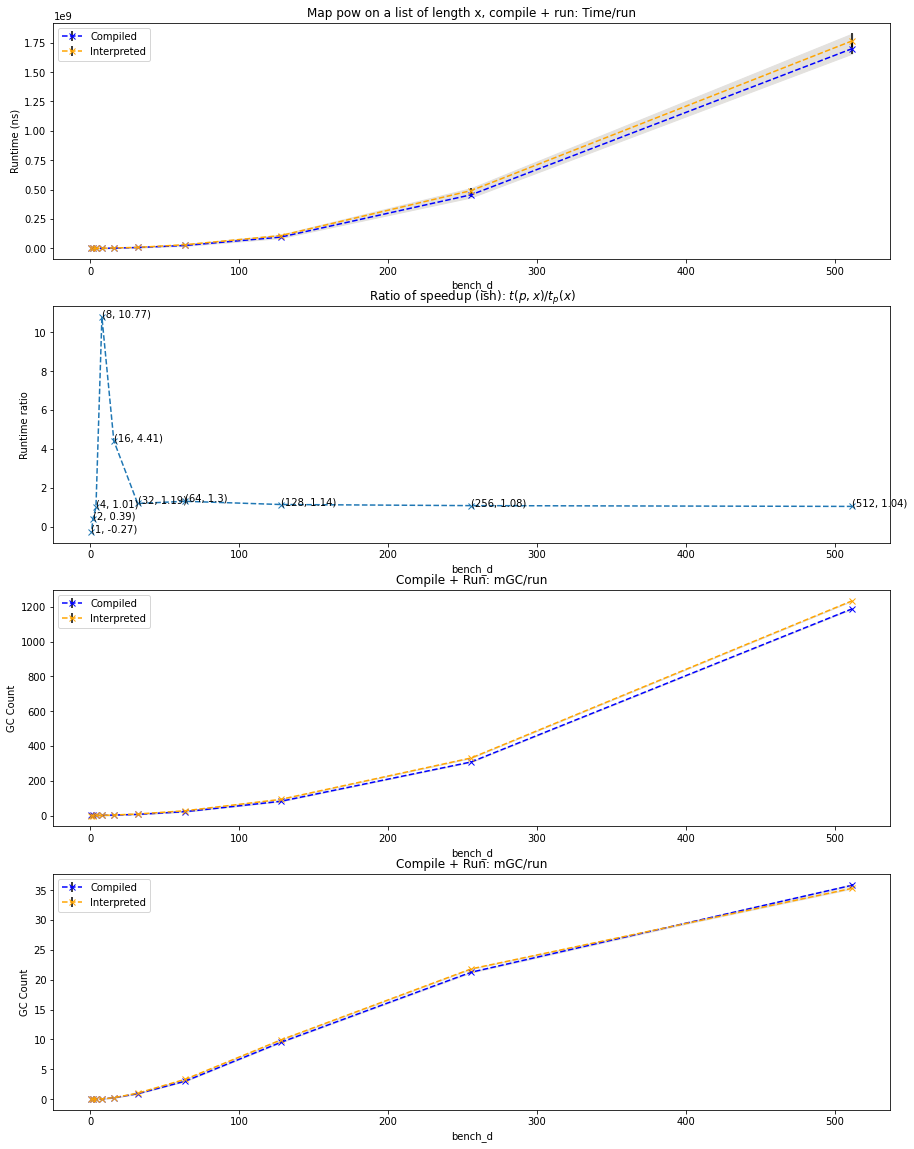

In [45]:
plot_for(df_list_map_7[df_list_map_7['benchmark_name'].str.startswith('map_pow_16')], 'bench_d', mean_offset, lo_offset, hi_offset)